In [84]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set()
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
import math

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
df = pd.read_csv("fandango.csv")

In [66]:
df.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [67]:
df.rename(columns={'Metacritic_user_norm_round':'Metacritic_user_norm'},inplace=True)

In [68]:
ranking_list = ['Fandango_Stars','RT_user_norm','RT_norm','IMDB_norm','Metacritic_user_norm','Metacritic_norm']

In [69]:
def my_heatmap(df):
    import seaborn as sns
    fig, axes = plt.subplots()
    sns.heatmap(df,annot=True)
    plt.show()
    plt.close()

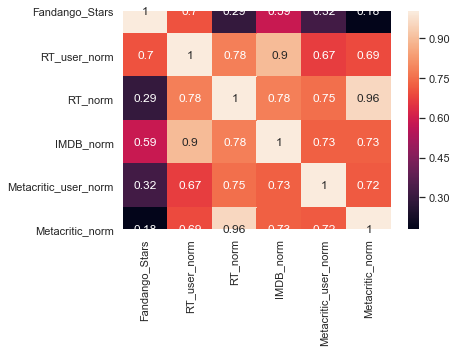

In [70]:
my_heatmap(df[ranking_list].corr(method='pearson'))

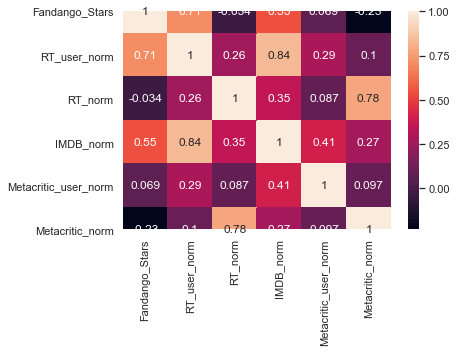

In [71]:
RT_lst = df['RT_norm']>=4
my_heatmap(df[RT_lst][ranking_list].corr(method='pearson'))

In [72]:
feature_cols = ['Fandango_Stars','RT_user_norm','RT_norm','Metacritic_user_norm','Metacritic_norm']
X = df.loc[:,feature_cols]

In [73]:
X.head(3)

,Fandango_Stars,RT_user_norm,RT_norm,Metacritic_user_norm,Metacritic_norm
0,5.0,4.3,3.70,3.5,3.30
1,5.0,4.0,4.25,4.0,3.35
2,5.0,4.5,4.00,4.0,3.20


In [74]:
Y = df['IMDB_norm']

In [75]:
x_train,x_test, y_train,y_test = train_test_split(X,Y, test_size=0.30, random_state=43)

In [76]:
dim = len(feature_cols)
print(dim)

5


In [77]:
dim +=1

In [78]:
x_train = x_train.assign(indpenedent = pd.Series([1]*len(y_train), index=x_train.index))
x_test = x_test.assign(indpenedent = pd.Series([1]*len(y_test), index=x_test.index))

In [79]:
i_train = x_train.as_matrix(columns=None)
i_test = x_test.as_matrix(columns=None)

o_train = np.array(y_train.values).reshape(-1,1)
o_test = np.array(y_test.values).reshape(-1,1)

In [80]:
P = tf.placeholder(tf.float32,[None,dim])
Q = tf.placeholder(tf.float32,[None,1])
T = tf.Variable(tf.ones([dim,1]))

In [81]:
bias = tf.Variable(tf.constant(1.0,shape=[dim]))
Q_ = tf.add(tf.matmul(P,T), bias)

In [82]:
cost = tf.reduce_mean(tf.square(Q_-Q))
learning_rate = 0.0001
training_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

In [49]:
init = tf.global_variables_initializer()
cost_history = np.empty(shape=[1], dtype=float)

In [50]:
training_epochs = 50000

with tf.Session() as sess:
    sess.run(init)
    cost_history = np.empty(shape=[1], dtype=float) 
    t_history = np.empty(shape=[dim,1], dtype=float)
    for epoch in range(training_epochs):
        sess.run(training_optimizer, feed_dict={P:i_train, Q:o_train})
        cost_history = np.append(cost_history, sess.run(cost,feed_dict={P:i_train, Q:o_train}))
        t_history = np.append(t_history, sess.run(T, feed_dict={P:i_train, Q:o_train}), axis=1)
    q_pred = sess.run(Q_,feed_dict={P:i_test})[:,0]
    mse = tf.reduce_mean(tf.square(q_pred-o_test))
    mse_tmp = mse.eval()
    sess.close()

In [51]:
print(mse_tmp)
RMSE = math.sqrt(mse_tmp)
print(RMSE)

0.4136536879397335
0.6431591466656861


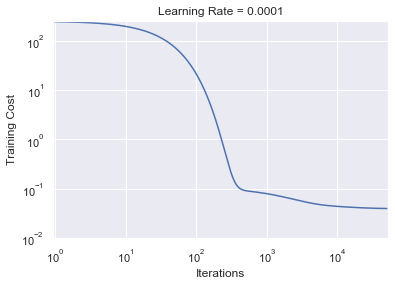

In [83]:
fig, axes = plt.subplots()
plt.plot(range(len(cost_history)), cost_history)
axes.set_xlim(xmin=0.95)
axes.set_ylim(ymin=1.e-2)
axes.set_xscale("log",nonposx='clip')
axes.set_yscale("log", nonposy='clip')
axes.set_ylabel("Training Cost")
axes.set_xlabel("Iterations")
axes.set_title("Learning Rate = " + str(learning_rate))
plt.show()
plt.close()

In [58]:
predictedDF = x_test.copy(deep=True)
predictedDF.insert(loc=0, column='IMDB_norm_predicted', value=pd.Series(data=q_pred,
                                                                    index=predictedDF.index))
predictedDF.insert(loc=0, column='IMDB_norm_actual' , value = o_test)
print('Predicted Vs Actual Rating (Using LR with Tensorflow)')
print(predictedDF[['IMDB_norm_actual','IMDB_norm_predicted']].head(10))

Predicted Vs Actual Rating (Using LR with Tensorflow)
     IMDB_norm_actual  IMDB_norm_predicted
45               3.30             3.180688
50               3.35             3.422704
98               3.05             2.899237
119              3.60             3.786441
133              2.15             2.515730
67               2.95             2.933743
101              2.20             2.733159
93               3.80             3.841654
131              3.35             3.151121
37               2.95             3.174279


In [59]:
print('Predicted Vs Actual Rating (Using LR with Tensorflow)')
print(predictedDF[['IMDB_norm_actual','IMDB_norm_predicted']].tail(10))

Predicted Vs Actual Rating (Using LR with Tensorflow)
     IMDB_norm_actual  IMDB_norm_predicted
72               3.70             3.780132
22               3.80             3.692823
55               3.30             3.492103
82               2.70             2.648021
71               3.90             3.723492
79               2.50             2.558301
103              2.85             2.943575
65               3.95             3.753253
138              3.60             3.661286
78               3.50             3.240240


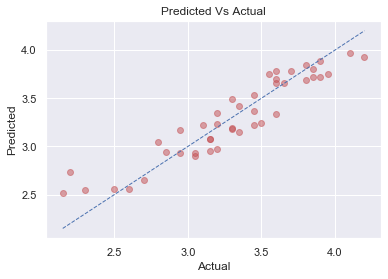

In [62]:
plt.scatter(o_test,q_pred, color='r', alpha=0.5)
plt.plot([o_test.min(), o_test.max()],[o_test.min(), o_test.max()], '--', lw=1)
plt.title('Predicted Vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()